# Chainerに用意されていないデータセットを使ってみよう

ここでは、Chainerに予め用意されていないデータセットを外部から調達して、Chainerで記述されたネットワークの訓練のために用いる方法を具体例とともに示します。基本的な手順はほぼ前節のCIFAR10データセットクラスを拡張する方法と変わりません。

ほとんど同様の内容を繰り返すことを避けるため、ここではChainerが用意するデータセットクラス用のユーティリティの一つである`get_cross_validation_datasets`を使い、5-foldクロスバリデーションを簡単に行う方法も合わせて説明してみます。

まずは、データセットをダウンロードしてきます。今回は、日本人では数少ないKaggle Grand Masterであらせられるnagadomiさんが[こちら](http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/)で配布されているアニメキャラクターの顔領域サムネイルデータセットを使用します。

In [1]:
%%bash
if [ ! -f animeface-character-dataset.zip ]; then
    curl -O http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
fi
if [ ! -d animeface-character-dataset ]; then
    unzip animeface-character-dataset.zip
fi
ls animeface-character-dataset

README.html
README.txt
index.html
thumb
tools


In [2]:
%%bash
if [ ! -f illust2vec_ver200.caffemodel ]; then
    curl -O http://illustration2vec.net/models/illust2vec_ver200.caffemodel
fi
if [ ! -f image_mean.npy ]; then
    curl -O http://illustration2vec.net/models/image_mean.npy
fi
ls illust2vec_ver200.caffemodel

illust2vec_ver200.caffemodel


In [49]:
%%bash
pip install -U seaborn

Requirement already up-to-date: six>=1.7.3 in /home/shunta/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages (from dataset)
  Running setup.py bdist_wheel for sqlalchemy: started
  Running setup.py bdist_wheel for sqlalchemy: finished with status 'done'
  Stored in directory: /home/shunta/.cache/pip/wheels/62/c3/8f/12a643439a7ba36143e21533ac633b99da8537b1deb8d0f0c3
  Running setup.py bdist_wheel for PyYAML: started
  Running setup.py bdist_wheel for PyYAML: finished with status 'done'
  Stored in directory: /home/shunta/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
  Running setup.py bdist_wheel for alembic: started
  Running setup.py bdist_wheel for alembic: finished with status 'done'
  Stored in directory: /home/shunta/.cache/pip/wheels/37/02/8e/1b941acb6b5c81a5c3cc10b6ac6532f488ee04c694544cfe6d
  Running setup.py bdist_wheel for normality: started
  Running setup.py bdist_wheel for normality: finished with status 'done'
  Stored in director

    DEPRECATION: Uninstalling a distutils installed project (sqlalchemy) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
    DEPRECATION: Uninstalling a distutils installed project (PyYAML) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.


今回はこちらのデータセットに含まれる画像を使って、キャラクターの顔画像を各キャラクターを表すクラスに分類してみます。ここでは、PILというパッケージを使用しますので、予めこれをインストールしておいてください。インストールは簡単で、pipを用いて以下のようにインストールできます。

```
% pip install PIL>=3.0
```

今回はバージョン3.0以上を想定しているため、バージョン指定を行っていますが、これをしない場合は自動的に最新版が入ります。

## 1. データセットクラスの作成

では、Chainerでオリジナルのデータセットクラスを作成する際の標準的な方法である `chainer.dataset.DatasetMixin` クラスを継承したクラスを書くという作業を行っていきます。ここでは、すでにクラス変数として定義している `IMG_DIR` にダウンロード済みのキャラクター顔画像のサムネイルが含まれたディレクトリが存在しているとします。このディレクトリはさらに、各キャラクターごとのディレクトリを含んでいます。つまり、各画像がどのキャラクターを表しているかというラベルに相当する情報がディレクトリ名を見ればわかるようになっているということです。そのため、このデータセットクラスでは画像のファイルパスからディレクトリ名を取り出して、それに一意に対応するIDを割り振る形でラベルを用意します。

また、後述するように今回は[Illustraction2Vec](http://illustration2vec.net/)という論文で提案されているモデルをpre-trainedモデルとして用いることにします。つまり、animeface-character-datasetを使ってこのIllst2Vecモデルをfine-turningすることになります。この場合、今回用いる新しいデータセットをモデルに入力する際には、各画像からpre-trainingの際に用いたのと同じ前処理（standardizationやwhiteningなどを含む）を行う必要があります。そのため、データセットクラスのクラス変数として `MEAN_FILE` を定義しておき、ここにIllustration2Vecのサイトからダウンロードしてきた平均値データを指すパスを入れておきます。これを今回用いるanimeface-character-datasetのデータの前処理の際に用いることにします。

それでは、実際にデータセットクラスを書いてみます。

In [3]:
import glob
import os

import numpy as np

import matplotlib
matplotlib.use('Agg')

from PIL import Image
from chainer import dataset
from chainer import datasets


class AnimeFaceDataset(dataset.DatasetMixin):
    
    IMG_DIR = 'animeface-character-dataset/thumb'
    IMG_SIZE = (160, 160)
    MEAN_FILE = 'image_mean.npy'
    
    def __init__(self):
        
        # thumbディレクトリ以下のディレクトリを列挙します。
        img_dirs = [d for d in glob.glob('{}/*'.format(self.IMG_DIR))
                    if os.path.isdir(d)]
        
        # 画像ファイルのパスを格納する空のリストを定義しておきます。
        self.img_fns = []
        
        for dname in img_dirs:
            
            # ignoreファイルが置かれているディレクトリは空か、
            # "分類の難易度が高い" (データセット配布元のREADME参照)
            # ため、スキップします。
            
            if len(glob.glob('{}/ignore'.format(dname))):
                continue
            
            # 画像ファイルへのパスのリストを追加していきます。
            self.img_fns += glob.glob('{}/*.png'.format(dname))
        
        # 各画像に対応するクラスIDをディレクトリ名から決定するためのリストです。
        self.cls_labels = list(set(os.path.dirname(fn)
                                   for fn in self.img_fns))
        
        # 使用するpre-trainedモデルに合わせて平均値ファイルを準備しておきます。
        self.mean = np.load(self.MEAN_FILE)
        self.mean = self.mean.mean(axis=(1, 2))
    
    def __len__(self):
        return len(self.img_fns)
    
    def get_example(self, i):
        
        # PILを使って画像を開き、画像サイズを揃えるためresizeします。
        img = Image.open(self.img_fns[i])
        img = img.resize(self.IMG_SIZE, Image.BICUBIC)
        img = np.asarray(img, dtype=np.float)
        
        # PNG画像はアルファチャンネルも含む場合があるので、
        # 4チャンネル以上の画像の場合は初めの3チャンネルを使用するようにします。
        if img.shape[0] > 3:
            img = img[:, :, :3]
            
        # PILで読み込んだ画像はRGBオーダになっているので、BGRオーダにします。
        img = img.transpose(2, 0, 1)[::-1, ...]
        
        # あらかじめ用意しておいた画素値の平均値を全ピクセルからチャンネルごとに引きます。
        img -= self.mean[:, None, None]
        
        # 画像の型をfloat32にします。
        img = img.astype(np.float32)
            
        # 同一ディレクトリ名から同一のクラスラベルIDが引かれるようにします。
        dname = os.path.dirname(self.img_fns[i])
        label = np.asarray(self.cls_labels.index(dname), dtype=np.int32)
        
        return img, label
    
d = AnimeFaceDataset()
train, valid = datasets.split_dataset_random(d, int(len(d) * 0.75), seed=0)

上のコードブロックにおけるポイントは、最後の行で `datasets.split_dataset_random` を使って、1つ前の行で作成したデータセットオブジェクトの75%のデータでできている訓練用サブセットと、残りの25%でできている検証用サブセットに分割している点です。`split_dataset_random`は、分割したいデータセットオブジェクトと、分割を行う区切り目の位置（ここではデータセット全体の大きさ（`len(d)`で与えられる）の75%の位置をしていしています）を与えると、元のデータセット内のデータの順番をシャッフルしたうえで指定された位置でのデータセットの分割を行い、分割後の部分データセット2つを返します。それをそれぞれ、`train`、`valid`とし、このあとの訓練で用いることにします。

## 2. モデルの定義とFine-tuningの準備

ここではIllust2Vecのモデルをベースとし、3つの全結合層をその上に乗っけた新しいモデルを定義します。ただし、Illust2Vecの上から3層目以下の部分は、Illust2Vecの論文に書かれた設定とデータセットを用いて訓練済みの重みをそのままにした状態で流用します。そして、この部分の重みは学習時に更新せず固定して、新たに追加した3つの全結合層だけを訓練します。

Illust2Vecの訓練済みパラメータは前述の方法でダウンロード済みなので、これをまず読み込みます。この訓練済みパラメータはcaffemodelの形式で提供されていますが、Chainerには非常に簡単にCaffeの訓練済みモデルを読み込む機能（`CaffeFunction`）があるので、これを使ってパラメータ（とモデル構造）をロードします。ただし、読み込みには時間がかかるため、一度読み込んだ際に得られる`Chain`オブジェクトをPython標準の`pickle`を使ってファイルに保存しておきます。こうすることで次回からの読み込みが速くなります。

In [4]:
import pickle

import chainer
import chainer.links as L
import chainer.functions as F

from chainer import Chain
from chainer.links.caffe import CaffeFunction
from chainer import serializers

n_classes = len(d.cls_labels)

class Illust2Vec(Chain):

    CAFFEMODEL_FN = 'illust2vec_ver200.caffemodel'
    PKL_FN = 'illust2vec_ver200.pkl'

    def __init__(self, n_classes):
        w = chainer.initializers.HeNormal()
        
        # 変換済みのChainerモデル（PKLファイル）が無い場合
        if not os.path.exists(self.PKL_FN):
            
            # CaffeModelを読み込んで保存します。（時間がかかります）
            model = CaffeFunction(self.CAFFEMODEL_FN)
            
            # 一度読み込んだら、次回から高速に読み込めるようPickleします。
            pickle.dump(model, open(self.PKL_FN, 'wb'))
        else:
            model = pickle.load(open(self.PKL_FN, 'rb'))
            
        # メモリ節約のため不要なレイヤを削除します。
        del model.encode1
        del model.encode2
        del model.forwards['encode1']
        del model.forwards['encode2']
        model._children.pop()
        model._children.pop()
        model.layers = model.layers[:-2]
        
        # 元のIllust2Vecモデルをtrunkとしてこのモデルに含めます。
        super(Illust2Vec, self).__init__(
            trunk=model,
            fc6=L.Linear(None, 4096, initialW=w),
            fc7=L.Linear(4096, 4096, initialW=w),
            fc8=L.Linear(4096, n_classes, initialW=w))
        self.train = True

    def __call__(self, x):
        # 元のIllust2Vecモデルのconv6_3の出力を取り出します。
        h = self.trunk({'data': x}, ['conv6_3'], train=self.train)[0]
        
        # conv6_3より前のパラメータは固定し、更新しないようにします。
        # これにより、ここより上のパラメータだけが最適化の対象になるため
        # GPUメモリに乗る勾配の数が減ってメモリ消費量がおさえられ、
        # また更新処理の対象も減るので学習も高速になります。
        h.unchain_backward()
        
        # ここ以降は新しく追加した層です。
        h = F.dropout(F.relu(self.fc6(h)), train=self.train)
        h = F.dropout(F.relu(self.fc7(h)), train=self.train)
        return self.fc8(h)
        
model = Illust2Vec(n_classes)
model = L.Classifier(model)

`__call__` の部分で `h.unchain_backward()` という見慣れない記述が登場しました。ここで行われていることを理解するために、Chainerの特徴である Define-by-Run の仕組みをもう一度簡単に整理してみましょう。

1. Functionが出力したVariableは、自身を計算したFunctionへの参照を `creator` というプロパティに保持している
2. モデルのbackward計算は、Variableの `creator` と、それが指すFunctionの `inputs` プロパティを交互にたどっていくことで計算グラフの構造を逆向きに辿ることで行われる

そしてこの `unchain_backward` は、この「backward計算（パラメータ更新のための勾配の計算）を行うためのレイヤ間の接続情報を、このメソッドが呼ばれた中間出力Variableに繋がって来ている全てにおいて切断する」ということを意味します。

Define-by-RunによるChainerのautogradの仕組みについては、こちらの記事を参照してください。: [1-file Chainerを作る](http://qiita.com/mitmul/items/37d3932292cdd560d418)

# 3. 学習

それでは、このデータセットとモデルを用いて、学習を行ってみます。

In [5]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions
from chainer.dataset import concat_examples


batchsize = 128
gpu_id = 0


class TestModeEvaluator(extensions.Evaluator):
    
    def evaluate(self):
        model = self.get_target('main')
        model.train = False
        ret = super(TestModeEvaluator, self).evaluate()
        model.train = True
        return ret


def create_lr_drop(drop_ratio=0.1):
    @training.make_extension()
    def lr_drop(trainer):
        trainer.updater.get_optimizer('main').lr *= drop_ratio
    return lr_drop


train_iter = iterators.MultiprocessIterator(train, batchsize)
valid_iter = iterators.MultiprocessIterator(
    valid, batchsize, repeat=False, shuffle=False)

optimizer = optimizers.MomentumSGD(lr=0.01)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0005))

updater = training.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (120, 'epoch'), out='AnimeFace-result')
trainer.extend(extensions.LogReport())
trainer.extend(extensions.observe_lr())

trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'main/accuracy',
     'validation/main/loss', 'validation/main/accuracy',
     'elapsed_time', 'lr']))

# ロスのプロットを毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/loss', 'validation/main/loss'],
        'epoch', file_name='loss.png'))

# 精度のプロットも毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# モデルのtrainプロパティをFalseに設定してvalidationするextension
trainer.extend(TestModeEvaluator(valid_iter, model, device=gpu_id))

# 指定したエポックごとに学習率を10分の1にする
trainer.extend(create_lr_drop(drop_ratio=0.1), trigger=(40, 'epoch'))

trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time  lr        
1           4.37604     0.442232       1.67663               0.653715                  17.3881       0.01        
2           1.41571     0.709507       1.36179               0.725217                  33.0419       0.01        
3           1.05118     0.777069       1.23818               0.749822                  48.7065       0.01        
4           0.896962    0.807813       0.987065              0.797695                  64.2682       0.01        
5           0.694213    0.839128       0.920076              0.80635                   79.9699       0.01        
6           0.581587    0.864217       0.892304              0.816862                  95.6558       0.01        
7           0.466379    0.883913       0.765059              0.832812                  111.476       0.01        
8           0.396946    0.897321       0.701147              0.851541                  127

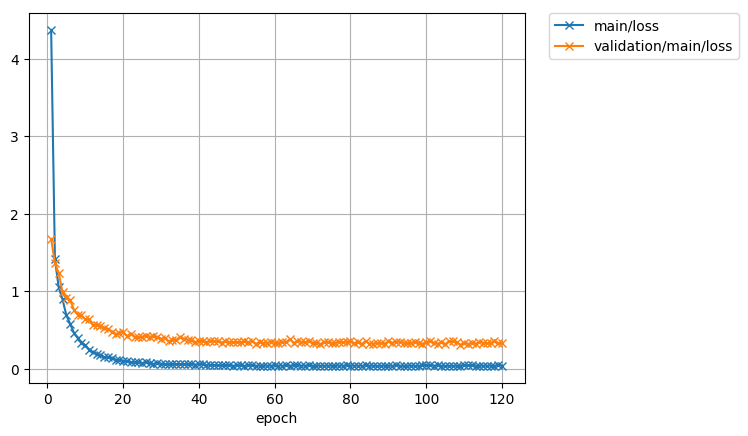

In [50]:
from IPython.display import Image
Image(filename='AnimeFace-result/loss.png')

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from chainer import cuda

pred: 000_hatsune_miku label: 000_hatsune_miku True


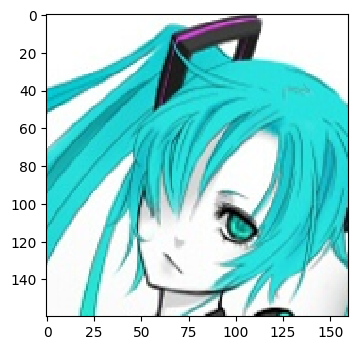

pred: 068_miyamura_miyako label: 068_miyamura_miyako True


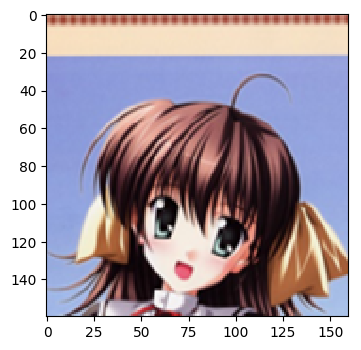

pred: 067_feena_fam_earthlight label: 067_feena_fam_earthlight True


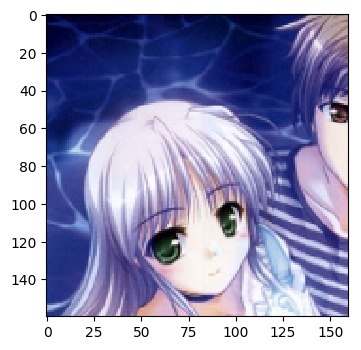

pred: 003_fate_testarossa label: 003_fate_testarossa True


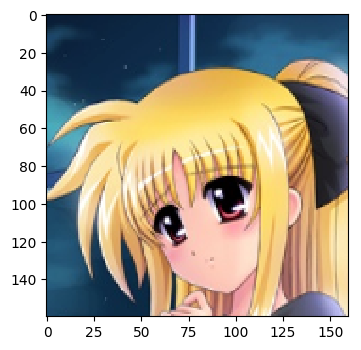

pred: 154_kobayakawa_yutaka label: 154_kobayakawa_yutaka True


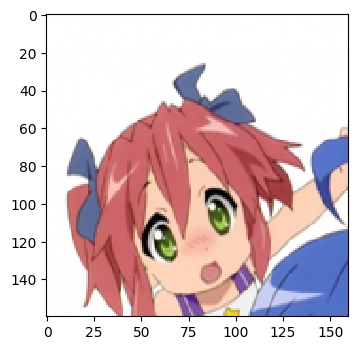

pred: 090_minase_iori label: 090_minase_iori True


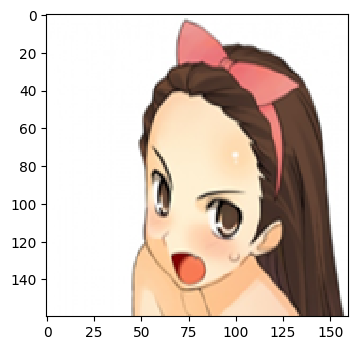

pred: 031_kotobuki_tsumugi label: 031_kotobuki_tsumugi True


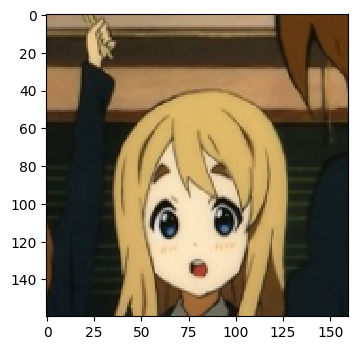

pred: 138_kanu label: 138_kanu True


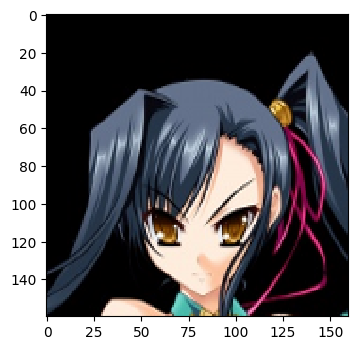

pred: 189_akizuki_ritsuko label: 189_akizuki_ritsuko True


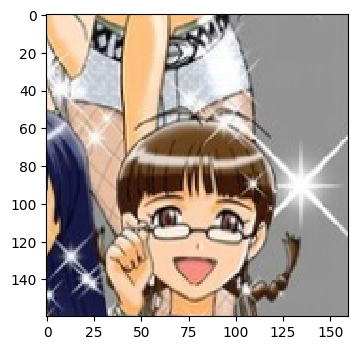

pred: 003_fate_testarossa label: 003_fate_testarossa True


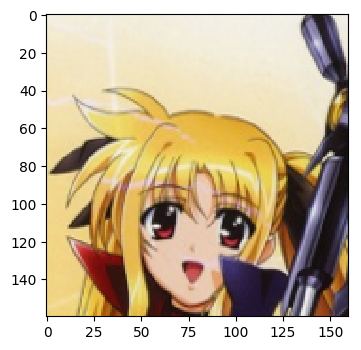

pred: 190_kawashima_ami label: 190_kawashima_ami True


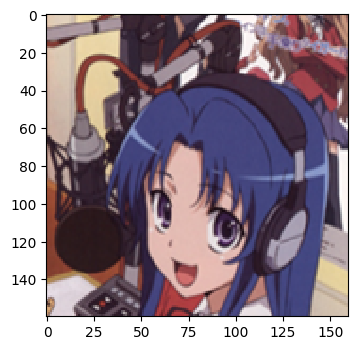

pred: 140_seto_san label: 140_seto_san True


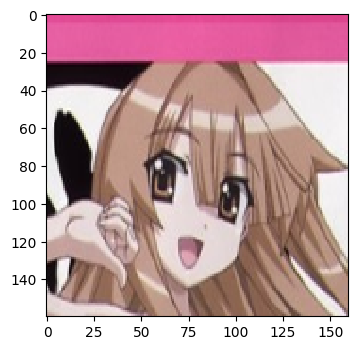

pred: 062_matou_sakura label: 062_matou_sakura True


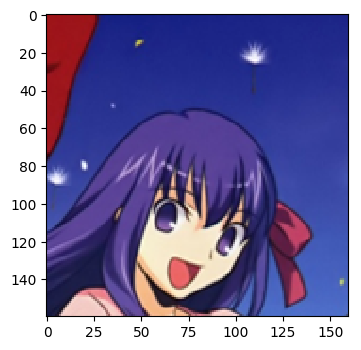

pred: 089_shigure_asa label: 089_shigure_asa True


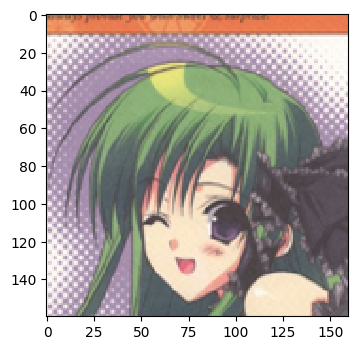

pred: 042_tsukimura_mayu label: 042_tsukimura_mayu True


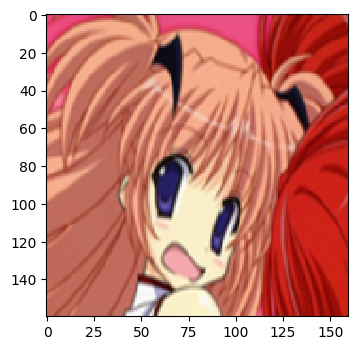

In [45]:
for _ in range(15):
    x, t = valid[np.random.randint(len(valid))]
    x = cuda.to_gpu(x)
    y = F.softmax(model.predictor(x[None, ...]))

    pred = os.path.basename(d.cls_labels[int(y.data.argmax())])
    label = os.path.basename(d.cls_labels[t])
    
    print('pred:', pred, 'label:', label, pred == label)

    x = cuda.to_cpu(x)
    x += d.mean[:, None, None]

    plt.imshow(x.transpose(1, 2, 0)[:, :, ::-1] / 255.0)
    plt.show()